In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import pydot

In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/fruit",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/fruit",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3147 files belonging to 2 classes.
Using 2518 files for training.
Found 3147 files belonging to 2 classes.
Using 629 files for validation.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

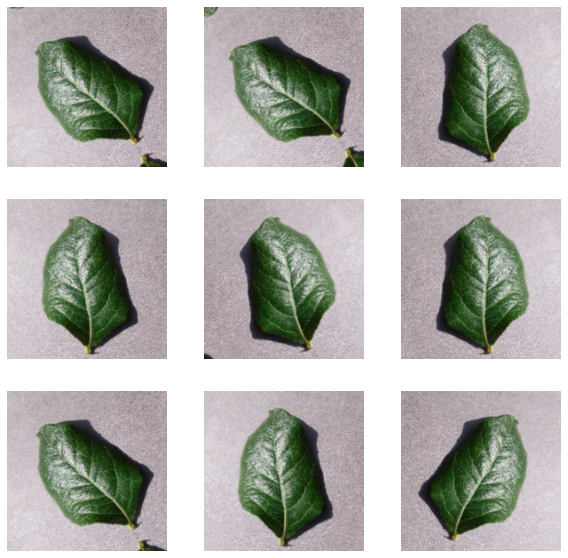

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))



train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]


In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
79/79 [==============================] - 1367s 17s/step - loss: 0.2903 - accuracy: 0.8871 - val_loss: 0.7454 - val_accuracy: 0.5151
Epoch 2/25
79/79 [==============================] - 750s 9s/step - loss: 0.1177 - accuracy: 0.9572 - val_loss: 1.3702 - val_accuracy: 0.5151
Epoch 3/25
79/79 [==============================] - 731s 9s/step - loss: 0.0843 - accuracy: 0.9696 - val_loss: 2.3003 - val_accuracy: 0.5151
Epoch 4/25
79/79 [==============================] - 728s 9s/step - loss: 0.0674 - accuracy: 0.9757 - val_loss: 2.6260 - val_accuracy: 0.5151
Epoch 5/25
79/79 [==============================] - 728s 9s/step - loss: 0.0497 - accuracy: 0.9845 - val_loss: 3.6974 - val_accuracy: 0.5151
Epoch 6/25
79/79 [==============================] - 727s 9s/step - loss: 0.0644 - accuracy: 0.9781 - val_loss: 2.6445 - val_accuracy: 0.5167
Epoch 7/25
79/79 [==============================] - 728s 9s/step - loss: 0.0800 - accuracy: 0.9675 - val_loss: 4.7759 - val_accuracy: 0.5167
Epoch 8/25


In [18]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/fruit/Blueberry/1cfe804c-e244-4a0f-8cef-26423d63087e___RS_HL 2394.JPG", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent apple and %.2f percent other."
    % (100 * (1 - score), 100 * score)
)

This image is 0.05 percent apple and 99.95 percent other.
